In [2]:
#!pip install datasets 'tensorflow==2.15'
!pip show tensorflow # This notebook was designed for version 2.15 (which seems to be not available), so I'm going to try run it with the default installed version 2.19

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [1]:
!pip install gensim # Because I was getting "ModuleNotFoundError: No module named 'gensim'" in line 6 "from gensim.models import Word2Vec"
# Note: It forced a re-start after the installation of new versions of numpy,scipy (to be compatible with gensim 4.3.3, the current version of gensim at Oct 2 2025)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TextVectorization, GRU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
from datasets import load_dataset
import numpy as np

# Enable CuDNN for GRU if a GPU is available
if tf.config.list_physical_devices('GPU'):
    GRU_LAYER = lambda units, return_sequences=False: tf.keras.layers.GRU(
        units, return_sequences=return_sequences, recurrent_activation='sigmoid')
else:
    GRU_LAYER = lambda units, return_sequences=False: tf.keras.layers.GRU(
        units, return_sequences=return_sequences, dropout=0.15, recurrent_dropout=0.5)

# Load the IMDb dataset from Hugging Face
dataset = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

from copilot (regarding line 11 below)**Overfitting**
Define "greedy by adding epochs" in the context of rnn
The term "greedy by adding epochs" in the context of RNNs refers to the concept of overfitting, where the model learns the noise in the training data and fails to generalize to unseen data. This occurs when the model has learned the patterns in the training data so well that it can predict the next input based on the previous inputs without considering the context. By adding more epochs, the model can potentially learn more noise in the training data, leading to overfitting. This is a common issue in deep learning, where the model can become overly dependent on the training data and lose its ability to generalize to new data.

In [3]:
# Preprocess the dataset
max_vocab_size = 25000  # Limit vocabulary size
max_seq_len = 50       # Maximum sequence length
embedding_dim = 150
latent_dim = 512  # Increased latent dimension for GRU
output_dim = 2

# Train Word2Vec embeddings using gensim
sentences = [text.split() for text in dataset['train']['text']]
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4) # could add , epochs=10) to make it more greedy and train more

# Create embedding matrix
def create_embedding_matrix(word_index, word2vec_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return embedding_matrix

# TextVectorization layer for preprocessing
vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_seq_len
)

# Adapt the TextVectorization layer to the training data
vectorizer.adapt(dataset['train']['text'])

# Get the vocabulary and create the embedding matrix
vocab = vectorizer.get_vocabulary()
word_index = {word: idx for idx, word in enumerate(vocab)}
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, embedding_dim)

In [4]:
# Create TensorFlow datasets
train_texts = tf.convert_to_tensor(dataset['train']['text'])
train_labels = tf.convert_to_tensor(dataset['train']['label'])
test_texts = tf.convert_to_tensor(dataset['test']['text'])
test_labels = tf.convert_to_tensor(dataset['test']['label'])

# Vectorize and preprocess text data
def preprocess_texts(text, label):
    text = vectorizer(text)
    label = tf.one_hot(label, depth=2)
    return text, label

train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
train_ds = train_ds.map(preprocess_texts).shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))
test_ds = test_ds.map(preprocess_texts).batch(256).prefetch(tf.data.AUTOTUNE)


In [8]:
# Encoder-only architecture
class SentimentClassifier(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, latent_dim, output_dim, embedding_matrix):
        super(SentimentClassifier, self).__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, mask_zero=True)
        self.dropout = Dropout(0.25)
        self.gru = GRU_LAYER(latent_dim, return_sequences=False)
        self.dense = tf.keras.layers.Dense(output_dim, activation="softmax")

    # Added by Gemini after getting the following error:
    # /usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer
    # 'sentiment_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state.
    # This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to
    # implement a proper `build()` method.
    #
    # Gemini said:
    # The model is not being built correctly, which is why the training is failing. I'll fix the build method in the SentimentClassifier class
    # to correctly build the model layers.

    # after that I got the followng NEW error when trying to use the added build function
    # AttributeError: 'Embedding' object has no attribute 'output_shape'

    # So Gemini said:
    # It seems like the embedding layer hasn't been built yet when the build method is called. A simpler way to handle this in a custom model
    # is to build the layers in the call method during the first pass. I'll remove the build method and let Keras handle the building
    # automatically.

    # So I commented "## " the lines it was trying to remove


    ## def build(self, input_shape):
    ##     self.gru.build(input_shape=(input_shape[0], input_shape[1], self.embedding.output_shape[-1]))
    ##     self.dense.build(input_shape=(input_shape[0], self.gru.output_shape[-1]))
    ##     super(SentimentClassifier, self).build(input_shape)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x = self.gru(x)
        outputs = self.dense(x)
        return outputs

# Instantiate the model
sentiment_model = SentimentClassifier(len(vocab), embedding_dim, latent_dim, output_dim, embedding_matrix)

## # Build the model
## sentiment_model.build(input_shape=(None, max_seq_len))

# Compile the model
sentiment_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
sentiment_model.summary()

Model: "sentiment_classifier_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     3,750,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,750,000 (14.31 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,750,000 (14.31 MB)

This was the expected result in the video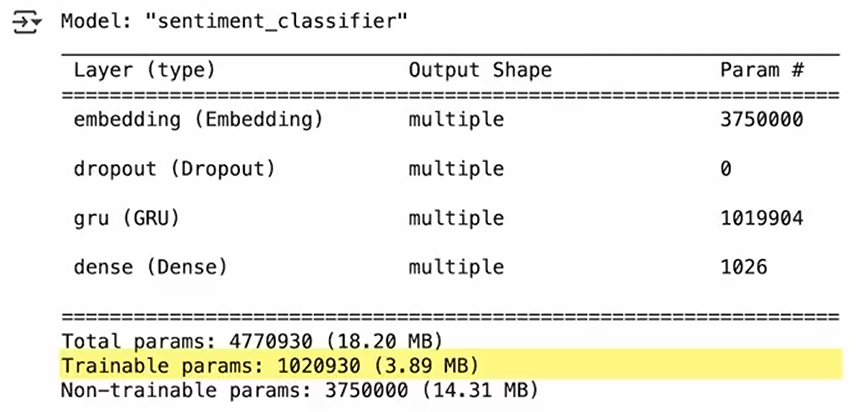

In [9]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
sentiment_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping]
)


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.7739 - loss: 0.5535 - val_accuracy: 0.6300 - val_loss: 0.6437
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.7651 - loss: 0.4905 - val_accuracy: 0.5265 - val_loss: 0.7412
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.7381 - loss: 0.5911 - val_accuracy: 0.6604 - val_loss: 0.6140
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7765 - loss: 0.5139 - val_accuracy: 0.6369 - val_loss: 0.6452
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.7601 - loss: 0.5561 - val_accuracy: 0.6559 - val_loss: 0.6226
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.7634 - loss: 0.5472 - val_accuracy: 0.6836 - val_loss: 0.5831
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.7754 - loss: 0.5114 - val_accuracy: 0.6860 - val_loss: 0.5931
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.7695 - loss: 0.5097 - val_accu

In [10]:
# Manual testing
sample_positive = "This was the best movie I have ever seen."
sample_negative = "This was the worst movie I have ever watched."
sample_neutral = "The movie was okay, not great but not terrible."
sample_sarcasm = "Wow, this was such a masterpiece... the actors, the screenplay, I could stay for hours if it wasn't for how bad it was."
sample_irony = "The plot was so riveting, I couldn’t stop yawning."

# Preprocess the samples
sample_positive_vectorized = vectorizer(tf.convert_to_tensor([sample_positive]))
sample_negative_vectorized = vectorizer(tf.convert_to_tensor([sample_negative]))
sample_neutral_vectorized = vectorizer(tf.convert_to_tensor([sample_neutral]))
sample_sarcasm_vectorized = vectorizer(tf.convert_to_tensor([sample_sarcasm]))
sample_irony_vectorized = vectorizer(tf.convert_to_tensor([sample_irony]))

# Predict sentiment
positive_prediction = sentiment_model.predict(sample_positive_vectorized)
negative_prediction = sentiment_model.predict(sample_negative_vectorized)
neutral_prediction = sentiment_model.predict(sample_neutral_vectorized)
sarcasm_prediction = sentiment_model.predict(sample_sarcasm_vectorized)
irony_prediction = sentiment_model.predict(sample_irony_vectorized)

print("Positive Prediction:", positive_prediction)
print("Negative Prediction:", negative_prediction)
print("Neutral Prediction:", neutral_prediction)
print("Sarcasm Prediction:", sarcasm_prediction)
print("Irony Prediction:", irony_prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Positive Prediction: [[0.01877789 0.9812221 ]]
Negative Prediction: [[0.96472853 0.03527145]]
Neutral Prediction: [[0.5687915  0.43120846]]
Sarcasm Prediction: [[0.74937546 0.25062457]]
Irony Prediction: [[0.47200772 0.52799225]]


Mis resultados fueron mejores que los del video. Tal vez porque use versiones más nuevas?
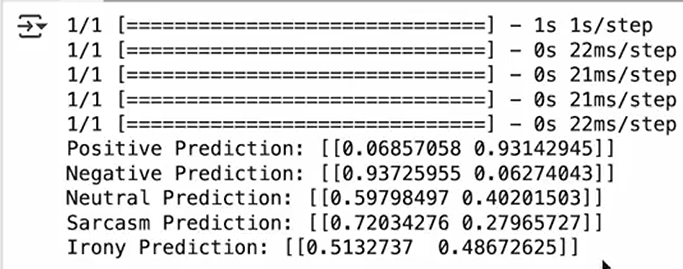